# Código

## Imports

In [ ]:
!pip install bokeh
!pip install networkx

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from prettytable import from_csv
import random

from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges

import networkx
from networkx.algorithms import community
from networkx.classes.graph import Graph
from networkx.algorithms.community.quality import modularity
from networkx.utils.mapped_queue import MappedQueue
from networkx.algorithms.dominating import dominating_set
from networkx.algorithms.simple_paths import all_simple_paths
from networkx.algorithms.bridges import bridges
from networkx.classes.function import degree_histogram, density

from dataclasses import dataclass
from pprint import pprint

In [ ]:
output_notebook()

## Filtros e Configurações

In [ ]:
@dataclass
class Filters:
    arithmetic_average: float = 0
    weighted_average: float = 0
    popularity: int = 0
    followers: int = 0


def filtering(filters: Filters, data_name: str):
  data = pd.read_csv(data_name).query(\
        "mean_arithmetic >= "+str(filters.__getattribute__("arithmetic_average"))+" \
        and mean_weighted >= "+str(filters.__getattribute__("weighted_average"))+" \
        and related_artist_popularity >= "+str(filters.__getattribute__("popularity"))+" \
        and related_artist_followers >= "+str(filters.__getattribute__("followers"))+"" 
        , engine='python')
  data.to_csv('./filtered_relations.csv', index=False)

## Gerador de grafos

### Função de detectar comunidades

In [ ]:
"""Functions for detecting communities based on modularity."""

__all__ = [
    "greedy_modularity_communities",
    "naive_greedy_modularity_communities",
    "_naive_greedy_modularity_communities",
]


def greedy_modularity_communities(G, weight=None, resolution=1, n_communities=1):
    # Count nodes and edges
    N = len(G.nodes())
    m = sum([d.get(weight, 1) for u, v, d in G.edges(data=True)])
    q0 = 1.0 / (2.0 * m)

    if (n_communities < 1) or (n_communities > N):
        raise ValueError(
            f"n_communities must be between 1 and {len(G.nodes())}. Got {n_communities}"
        )

    # Map node labels to contiguous integers
    label_for_node = {i: v for i, v in enumerate(G.nodes())}
    node_for_label = {label_for_node[i]: i for i in range(N)}

    # Calculate degrees
    k_for_label = G.degree(G.nodes(), weight=weight)
    k = [k_for_label[label_for_node[i]] for i in range(N)]

    # Initialize community and merge lists
    communities = {i: frozenset([i]) for i in range(N)}
    merges = []

    # Initial modularity
    partition = [[label_for_node[x] for x in c] for c in communities.values()]
    q_cnm = modularity(G, partition, resolution=resolution)

    # Initialize data structures
    # CNM Eq 8-9 (Eq 8 was missing a factor of 2 (from A_ij + A_ji)
    # a[i]: fraction of edges within community i
    # dq_dict[i][j]: dQ for merging community i, j
    # dq_heap[i][n] : (-dq, i, j) for communitiy i nth largest dQ
    # H[n]: (-dq, i, j) for community with nth largest max_j(dQ_ij)
    a = [k[i] * q0 for i in range(N)]
    dq_dict = {
        i: {
            j: 2
            * q0
            * G.get_edge_data(label_for_node[i], label_for_node[j]).get(weight, 1.0)
            - 2 * resolution * k[i] * k[j] * q0 * q0
            for j in [node_for_label[u] for u in G.neighbors(label_for_node[i])]
            if j != i
        }
        for i in range(N)
    }
    dq_heap = [
        MappedQueue([(-dq, i, j) for j, dq in dq_dict[i].items()]) for i in range(N)
    ]
    H = MappedQueue([dq_heap[i].h[0] for i in range(N) if len(dq_heap[i]) > 0])

    # Merge communities until we can't improve modularity or until desired number of
    # communities (n_communities) is reached.
    while len(H) > n_communities:
        # Find best merge
        # Remove from heap of row maxes
        # Ties will be broken by choosing the pair with lowest min community id
        try:
            dq, i, j = H.pop()
        except IndexError:
            break
        dq = -dq
        # Remove best merge from row i heap
        dq_heap[i].pop()
        # Push new row max onto H
        if len(dq_heap[i]) > 0:
            H.push(dq_heap[i].h[0])
        # If this element was also at the root of row j, we need to remove the
        # duplicate entry from H
        if dq_heap[j].h[0] == (-dq, j, i):
            H.remove((-dq, j, i))
            # Remove best merge from row j heap
            dq_heap[j].remove((-dq, j, i))
            # Push new row max onto H
            if len(dq_heap[j]) > 0:
                H.push(dq_heap[j].h[0])
        else:
            # Duplicate wasn't in H, just remove from row j heap
            dq_heap[j].remove((-dq, j, i))
        # Stop when change is non-positive
        if dq <= 0:
            break

        # Perform merge
        communities[j] = frozenset(communities[i] | communities[j])
        del communities[i]
        merges.append((i, j, dq))
        # New modularity
        q_cnm += dq
        # Get list of communities connected to merged communities
        i_set = set(dq_dict[i].keys())
        j_set = set(dq_dict[j].keys())
        all_set = (i_set | j_set) - {i, j}
        both_set = i_set & j_set
        # Merge i into j and update dQ
        for k in all_set:
            # Calculate new dq value
            if k in both_set:
                dq_jk = dq_dict[j][k] + dq_dict[i][k]
            elif k in j_set:
                dq_jk = dq_dict[j][k] - 2.0 * resolution * a[i] * a[k]
            else:
                # k in i_set
                dq_jk = dq_dict[i][k] - 2.0 * resolution * a[j] * a[k]
            # Update rows j and k
            for row, col in [(j, k), (k, j)]:
                # Save old value for finding heap index
                if k in j_set:
                    d_old = (-dq_dict[row][col], row, col)
                else:
                    d_old = None
                # Update dict for j,k only (i is removed below)
                dq_dict[row][col] = dq_jk
                # Save old max of per-row heap
                if len(dq_heap[row]) > 0:
                    d_oldmax = dq_heap[row].h[0]
                else:
                    d_oldmax = None
                # Add/update heaps
                d = (-dq_jk, row, col)
                if d_old is None:
                    # We're creating a new nonzero element, add to heap
                    dq_heap[row].push(d)
                else:
                    # Update existing element in per-row heap
                    dq_heap[row].update(d_old, d)
                # Update heap of row maxes if necessary
                if d_oldmax is None:
                    # No entries previously in this row, push new max
                    H.push(d)
                else:
                    # We've updated an entry in this row, has the max changed?
                    if dq_heap[row].h[0] != d_oldmax:
                        H.update(d_oldmax, dq_heap[row].h[0])

        # Remove row/col i from matrix
        i_neighbors = dq_dict[i].keys()
        for k in i_neighbors:
            # Remove from dict
            dq_old = dq_dict[k][i]
            del dq_dict[k][i]
            # Remove from heaps if we haven't already
            if k != j:
                # Remove both row and column
                for row, col in [(k, i), (i, k)]:
                    # Check if replaced dq is row max
                    d_old = (-dq_old, row, col)
                    if dq_heap[row].h[0] == d_old:
                        # Update per-row heap and heap of row maxes
                        dq_heap[row].remove(d_old)
                        H.remove(d_old)
                        # Update row max
                        if len(dq_heap[row]) > 0:
                            H.push(dq_heap[row].h[0])
                    else:
                        # Only update per-row heap
                        dq_heap[row].remove(d_old)

        del dq_dict[i]
        # Mark row i as deleted, but keep placeholder
        dq_heap[i] = MappedQueue()
        # Merge i into j and update a
        a[j] += a[i]
        a[i] = 0

    communities = [
        frozenset([label_for_node[i] for i in c]) for c in communities.values()
    ]
    return sorted(communities, key=len, reverse=True)

### Geral

In [ ]:
title = "Spotify Network" 

In [ ]:
@dataclass
class Configuration:
  def __init__(self, 
               name_data: str, 
               color: str, 
               degree_active: bool, 
               community_active: bool,
               responsive_highlighting_active: bool,
               label_active: bool
               ):
    self.data_frame = pd.read_csv(name_data)
    self.color = color
    self.degree_active = degree_active
    self.community_active = community_active
    self.responsive_highlighting_active = responsive_highlighting_active
    self.label_active = label_active

In [ ]:
def gerate_graph(config: Configuration):
    HOVER_TOOLTIPS = [("Artista", "@index")]

    G = networkx.from_pandas_edgelist(config.__getattribute__("data_frame"), 'artist', 'related_artist', 'mean_weighted')

    color_palette = config.__getattribute__("color")
    #Choose colors for node and edge highlighting
    node_highlight_color = 'white'
    edge_highlight_color = 'black'

    if config.__getattribute__("degree_active"):
      calculate_degree(G)
      HOVER_TOOLTIPS.append(("Grau", "@degree"))

      size_by_this_attribute = 'adjusted_node_size'
      color_by_this_attribute = 'adjusted_node_size'

    if config.__getattribute__("community_active"):
      modularity_class, modularity_color = calculate_communities(G)
      # Add modularity class and color as attributes from the network above
      networkx.set_node_attributes(G, modularity_class, 'modularity_class')
      networkx.set_node_attributes(G, modularity_color, 'modularity_color')

      size_by_this_attribute = 'adjusted_node_size'
      color_by_this_attribute = 'modularity_color'

      HOVER_TOOLTIPS.append(("Classe", "@modularity_class"))
      HOVER_TOOLTIPS.append(("Cor", "$color[swatch]:modularity_color"))

          
    #Create a plot — set dimensions, toolbar, and title
    plot = figure(tooltips = HOVER_TOOLTIPS,
                  tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
                x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title, plot_width=1200, plot_height=850)

    #Create a network graph object with spring layout
    network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))

    #Set node size and color
    if config.__getattribute__("degree_active") and not config.__getattribute__("community_active"):
      minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
      maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
      network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))
    
    elif config.__getattribute__("community_active"):
      network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
    
    else:
      network_graph.node_renderer.glyph = Circle(size=15, fill_color=color_palette)

    if config.__getattribute__("responsive_highlighting_active"):
      network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
      
      network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
      network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

    #Set edge opacity and width
    network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

    if config.__getattribute__("responsive_highlighting_active"):
      #Set edge highlight colors
      network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
      network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

      #Highlight nodes and edges
      network_graph.selection_policy = NodesAndLinkedEdges()
      network_graph.inspection_policy = NodesAndLinkedEdges()

    #Add network graph to the plot
    plot.renderers.append(network_graph)

    if config.__getattribute__("label_active"):
      #Add Labels
      x, y = zip(*network_graph.layout_provider.graph_layout.values())
      node_labels = list(G.nodes())
      source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
      labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='20px', background_fill_alpha=.7)
      plot.renderers.append(labels)

    show(plot)
    save(plot, filename=f"{title}.html")

    return G

In [ ]:
def calculate_degree(G: Graph):
  degrees = dict(networkx.degree(G))
  networkx.set_node_attributes(G, name='degree', values=degrees)

  number_to_adjust_by = 5
  adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in networkx.degree(G)])
  networkx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

In [ ]:
def calculate_communities(G: Graph):
  communities = greedy_modularity_communities(G)
  # Create empty dictionaries
  modularity_class = {}
  modularity_color = {}

  #Loop through each community in the network
  for community_number, community in enumerate(communities):
      #For each member of the community, add their community number and a distinct color
      for name in community: 
          modularity_class[name] = community_number
          modularity_color[name] = Spectral8[community_number]
          
  return modularity_class, modularity_color

## Grafos exemplos

### Grafo Básico

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='skyblue', 
                       degree_active=False, 
                       community_active=False, 
                       responsive_highlighting_active=False, 
                       label_active=False)
gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### Grafo com vertices dimensionados e coloridos por grau

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='Purples8', 
                       degree_active=True, 
                       community_active=False, 
                       responsive_highlighting_active=False, 
                       label_active=False)
G=gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### Grafo com vertices dimensionados por grau e coloridos por Comunidades

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='Green8', 
                       degree_active=True, 
                       community_active=True, 
                       responsive_highlighting_active=False, 
                       label_active=False)
gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### Grafo com destaque responsivo

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='Pink8', 
                       degree_active=True, 
                       community_active=True, 
                       responsive_highlighting_active=True, 
                       label_active=False)
gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


### Grafo com Labels

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='Blues8', 
                       degree_active=True, 
                       community_active=True, 
                       responsive_highlighting_active=True, 
                       label_active=True)
gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


## Análise de dados

### Funções

In [ ]:
def get_graph_info(G: Graph):
  print('{} Vertices e {} Arestas'.format(G.number_of_nodes(), G.number_of_edges()))

In [ ]:
def get_density(G: Graph):
  pprint(density(G))

In [ ]:
def get_degree_histogram(G: Graph):
  plt.figure(constrained_layout=True, figsize = (15, 9), facecolor = None)

  height = degree_histogram(G)
  qtd_graus = len(degree_histogram(G))

  bars = np.linspace(0, qtd_graus, qtd_graus, dtype=int)
  y_pos = np.arange(len(bars))

  # Create bars
  plt.bar(y_pos, height)

  # Create names on the x-axis
  
  plt.xticks(y_pos, bars)

  # Show graphic
  plt.show()

In [ ]:
def get_communicability(G: Graph):
  pprint(networkx.communicability(G))

In [ ]:
def get_average_neighbor_degree(G: Graph):

  averages = networkx.average_neighbor_degree(G)
  count = 0
  print("-- 10 menores --")
  for i in sorted(averages, key = averages.get):
    if count <= 10:
      print(i, averages[i])
    count += 1
  
  print("")
  count = 0
  print("-- 10 maiores --")
  for i in sorted(averages, key = averages.get):
    if count >= 130:
      print(i, averages[i])
    count += 1

In [ ]:
def get_degree_assortativity_coefficient(G: Graph):
  r = networkx.degree_assortativity_coefficient(G)
  print(f"{r:3.1f}")

In [ ]:
def get_bridges(G: Graph):
  random_numbers = random.sample(range(len(list(networkx.bridges(G)))), 10)
  pprint([list(networkx.bridges(G))[r] for r in random_numbers])

In [ ]:
def get_dominating_set(G: Graph):
  pprint(len(dominating_set(G, start_with=None)))
  pprint(dominating_set(G, start_with=None))

In [ ]:
def get_graphic_degree(G: Graph, num_nodes: int):
  degree_df = pd.DataFrame(G.nodes(data='degree'), columns=['node', 'degree'])
  degree_df = degree_df.sort_values(by='degree', ascending=False)[:num_nodes]

  sns.set(style="whitegrid")
  f, ax = plt.subplots(figsize=(6, 6))
  sns.barplot(x="degree", y="node", data=degree_df, label="Grau", palette="flare")

  ax.legend(ncol=2, loc="lower right", frameon=True)
  ax.set(xlim=(0, 50), ylabel="", xlabel="Grau")
  sns.despine(left=True, bottom=True)

In [ ]:
def get_graphic_weigth(name_data: str, num_nodes: int):
  weighted_degree_df = pd.read_csv(name_data)['mean_weighted']
  num_nodes_to_inspect = num_nodes
  weighted_degree_df[:num_nodes_to_inspect].plot(x='node', y='mean_weighted', color='orange', kind='barh').invert_yaxis()

In [ ]:
def get_betweenness_centrality(G: Graph, num_nodes: int):
  betweenness_centrality = networkx.betweenness_centrality(G)
  networkx.set_node_attributes(G, name='betweenness', values=betweenness_centrality)
  betweenness_df = pd.DataFrame(G.nodes(data='betweenness'), columns=['node', 'betweenness'])
  betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)[:num_nodes]

  sns.set(style="whitegrid")
  f, ax = plt.subplots(figsize=(6, 6))
  sns.barplot(x="betweenness", y="node", data=betweenness_df, label="Pontuação", palette="ch:s=.25,rot=-.25")

  ax.legend(ncol=2, loc="lower right", frameon=True)
  ax.set(xlim=(0, 0.3), ylabel="", xlabel="Pontuação de Intermediação")
  sns.despine(left=True, bottom=True)

In [ ]:
def get_eigenvector_centrality(G: Graph, num_nodes: int):
  eigenvector_centrality = networkx.eigenvector_centrality(G)
  networkx.set_node_attributes(G, name='betweenness', values=eigenvector_centrality)
  betweenness_df = pd.DataFrame(G.nodes(data='betweenness'), columns=['node', 'betweenness'])
  betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)[:num_nodes]

  sns.set(style="whitegrid")
  f, ax = plt.subplots(figsize=(6, 6))
  sns.barplot(x="betweenness", y="node", data=betweenness_df, label="Pontuação", palette="husl")

  ax.legend(ncol=2, loc="lower right", frameon=True)
  ax.set(xlim=(0, 0.6), ylabel="", xlabel="Centralidade de autovetor ")
  sns.despine(left=True, bottom=True)

In [ ]:
def get_communities(G: Graph):
  communities_df = pd.DataFrame(G.nodes(data='modularity_class'), columns=['node', 'modularity_class'])
  communities_df = communities_df.sort_values(by='modularity_class', ascending=False)

  mod_1 = communities_df[communities_df['modularity_class'] == 1][:20]
  mod_2 = communities_df[communities_df['modularity_class'] == 2][:20]
  mod_3 = communities_df[communities_df['modularity_class'] == 3][:20]
  mod_4 = communities_df[communities_df['modularity_class'] == 4][:20]

  return mod_1, mod_2, mod_3, mod_4

In [ ]:
def plot_word_cloud(data_name: str):
  artists = pd.read_csv(data_name, encoding='utf-8')["related_artist"]
  artist_list = ["'"+str(artist)+"'" for artist in artists]

  plt.figure(constrained_layout=True, figsize = (20, 9), facecolor = None)
  wordcloud = WordCloud(width = 2000, height = 1000, background_color ='white', min_font_size = 10).generate(' '.join(artist_list))
  plt.imshow(wordcloud)
  plt.title("Artists", fontsize=20)
  plt.axis("off")

  plt.show()

In [ ]:
def generate_neighbors_relations(data_name: str):
  neighbors = pd.read_csv(data_name, encoding='utf-8').query("artist == 'The Beatles'")
  neighbors.to_csv('./neighbors_relations.csv', index=False)

# **Grafos Spotify - The Beatles**

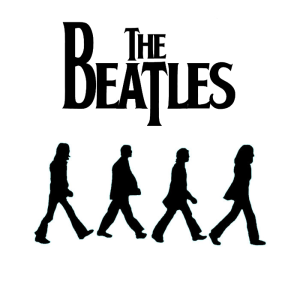

## spotify (2).png **API Spotify**

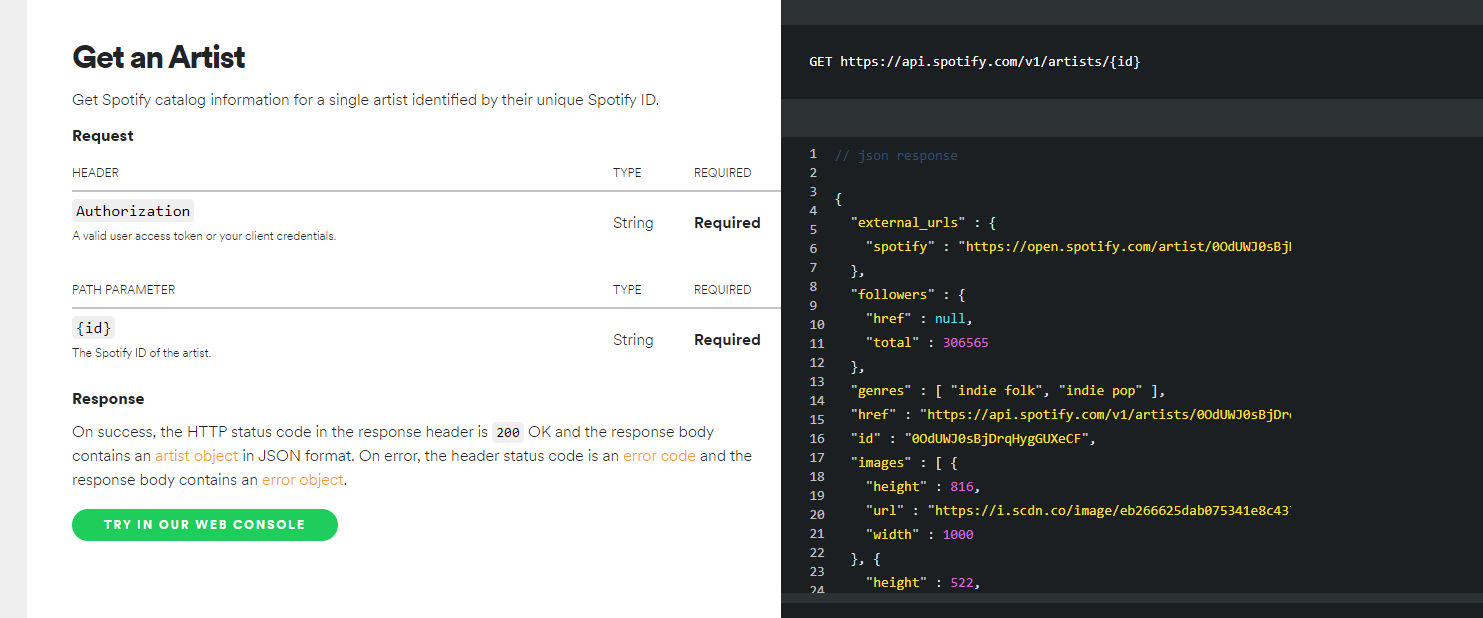

### **Metodologia**

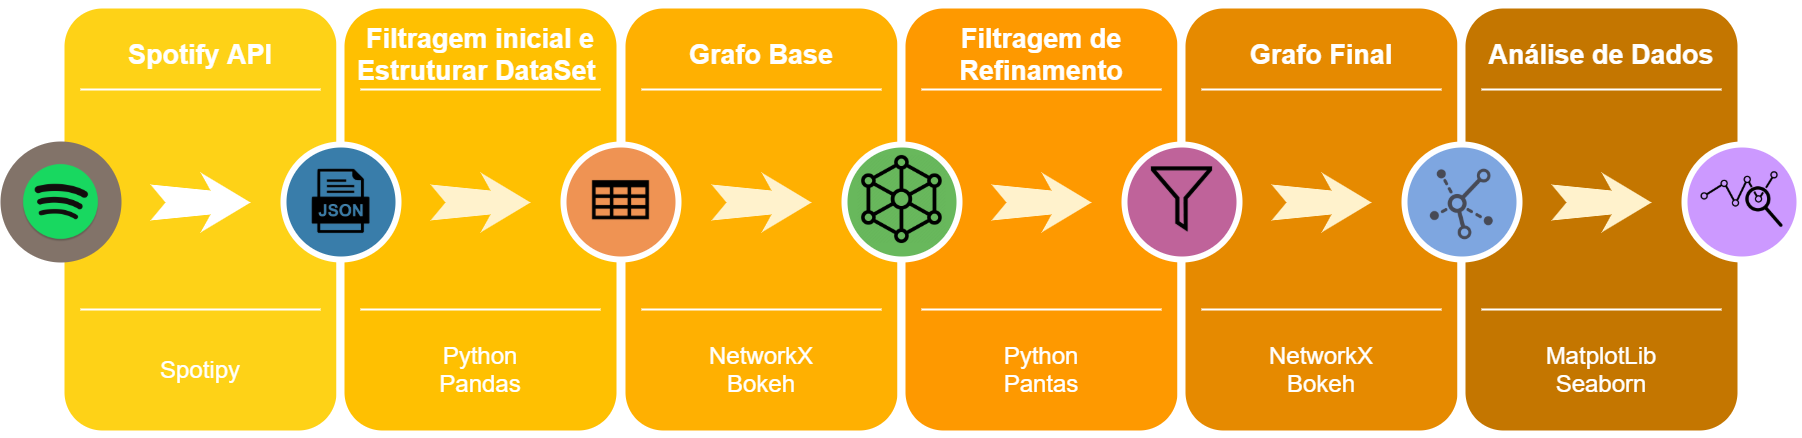

## **Configurações**

In [ ]:
#@title Filtros
#@markdown ---

popularity =  70#@param {type:"integer"}
followers =  400000#@param {type:"integer"}
#@markdown Média Artitmetica dos valores de Popularidade
arithmetic_average = 70 #@param {type:"integer"}
#@markdown  Média Ponderada dos valores de Popularidade com peso igual a quantidade de seguidores
weighted_average = 70 #@param {type:"integer"}


filters = Filters(
    arithmetic_average = arithmetic_average,
    weighted_average = weighted_average,
    popularity = popularity,
    followers = followers
)
filtering(filters, "relations.csv")

### Média Ponderada

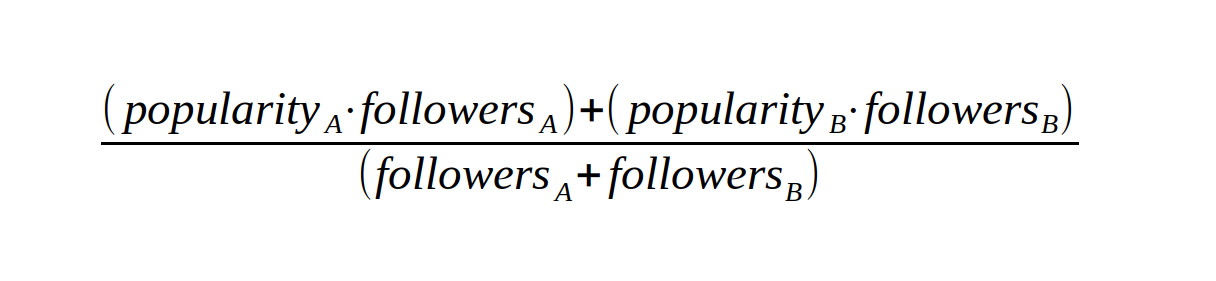

## connection.png **Grafo 01**

- Cores e dimensionamento dos vertices baseados no Grau;
- Filtros aplicados:
  - vertex_amount = 300
  - weighted_average >= 50
  - arithmetic_average >= 50
  - followers >= 1000 

In [ ]:
config = Configuration(name_data='relations.csv', 
                       color='Purples8', 
                       degree_active=True, 
                       community_active=False, 
                       responsive_highlighting_active=False, 
                       label_active=False)
G=gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


info.png **Informações do Grafo**

In [ ]:
# Quantidade de Vertices e Arestas
get_graph_info(G)

313 Vertices e 1208 Arestas


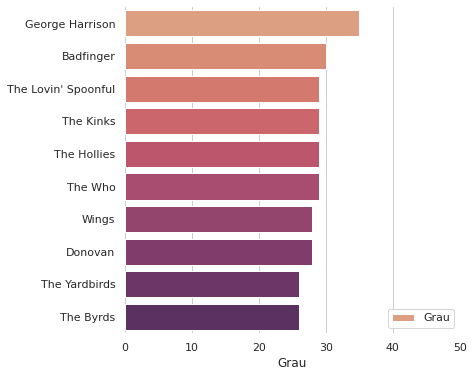

In [ ]:
# Os 10 artistas com maior grau
get_graphic_degree(G, num_nodes=10)

## connection.png  **Grafo 02**

- Cores baseadas em comunidades e dimensionamento dos vertices baseados no Grau;
- Filtros aplicados:
  - arithmetic_average >= 70
  - weighted_average >= 70
  - followers >= 300000

In [ ]:
config = Configuration(name_data='filtered_relations.csv',
                       color='Purples8',
                       degree_active=True,
                       community_active=True,
                       responsive_highlighting_active=True,
                       label_active=False)
G=gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


info.png **Informações do Grafo**

In [ ]:
# Quantidade de Vertices e Arestas
get_graph_info(G)

140 Vertices e 315 Arestas


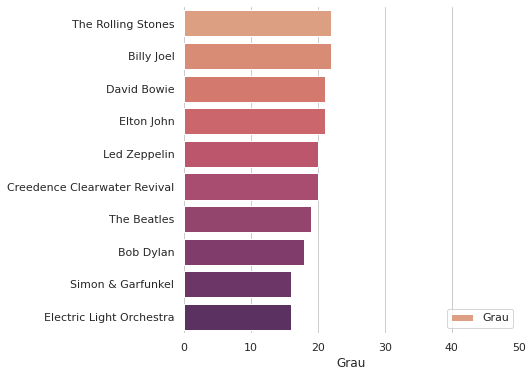

In [ ]:
# Os 10 artistas com maior grau
get_graphic_degree(G, num_nodes=10)

In [ ]:
# Retorna o grau médio da vizinhança de cada vertice.
get_average_neighbor_degree(G)

-- 10 menores --
Elvis Presley 2.6
David Bowie 3.0
Eric Clapton 4.4
Billy Joel 5.363636363636363
Led Zeppelin 5.55
Electric Light Orchestra 6.125
The Beach Boys 6.285714285714286
Creedence Clearwater Revival 6.5
Grateful Dead 7.0
Elton John 7.190476190476191
Van Morrison 7.4

-- 10 maiores --
Neil Diamond 21.0
Rod Stewart 21.0
Chicago 21.5
Daryl Hall & John Oates 21.5
Huey Lewis & The News 21.5
Little River Band 21.5
Faces 22.0
Kenny Loggins 22.0
REO Speedwagon 22.0
Eddie Money 22.0


In [ ]:
# Amostra aleatoria de 10 pontes
get_bridges(G)

[('Bob Dylan', 'Nick Drake'),
 ('Elvis Presley', 'The Drifters'),
 ('The Beach Boys', 'Harry Nilsson'),
 ('The Beatles', 'Donovan'),
 ('Billy Joel', 'Eddie Money'),
 ('Creedence Clearwater Revival', 'John Fogerty'),
 ('Led Zeppelin', 'Thin Lizzy'),
 ('Creedence Clearwater Revival', 'George Thorogood & The Destroyers'),
 ('Eric Clapton', 'B.B. King'),
 ('David Bowie', 'Roxy Music')]


## question-mark.png **Questões**

In [ ]:
config = Configuration(name_data='filtered_relations.csv', 
                       color='Purples8', 
                       degree_active=True, 
                       community_active=True, 
                       responsive_highlighting_active=True, 
                       label_active=False)
G=gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


1) Quais os artistas mais influentes no Spotify
presentes na rede do The Beatles?

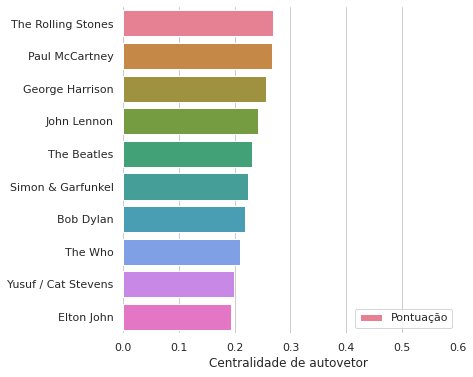

In [ ]:
# pontuação de centralidade de Autovetor
get_eigenvector_centrality(G, num_nodes=10)

2) Quais os artistas que poderiam ser sugeridos para
quem ouve The Beatles?

In [ ]:
generate_neighbors_relations(data_name='filtered_relations.csv')
config = Configuration(name_data='neighbors_relations.csv', 
                       color='Purples8', 
                       degree_active=True, 
                       community_active=False, 
                       responsive_highlighting_active=False, 
                       label_active=True)
gerate_graph(config)

/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/usr/local/lib/python3.7/dist-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [ ]:
# Artistas da Classe 1
mod_1, mod_2, mod_3, mod_4 = get_communities(G)
mod_1

,node,modularity_class
0,The Beatles,1
71,Paul Anka,1
14,Chuck Berry,1
31,The Turtles,1
30,Harry Nilsson,1
28,The Mamas & The Papas,1
27,The Monkees,1
18,Elvis Presley,1
1,John Lennon,1
15,Donovan,1


3) Quais os artistas poderiam fazer parcerias com o The Beatles numa relação de co-branding?

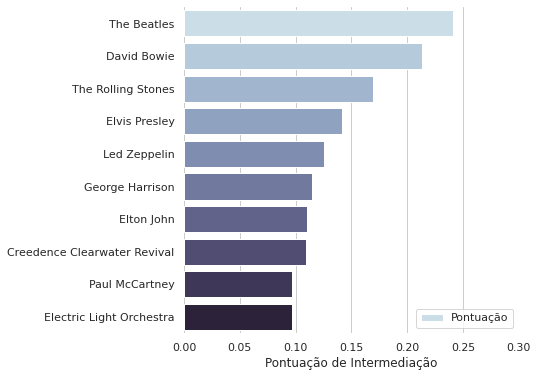

In [ ]:
# pontuação de centralidade de intermediação
get_betweenness_centrality(G, num_nodes=10)